# Dependencies

In [1]:
!pip install -q datasets opencv-python numpy tensorflow keras Keras-Applications huggingface_hub python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import load_dataset, DatasetDict
import cv2
import numpy as np
import pickle
from huggingface_hub import login
from huggingface_hub import HfApi
from google.colab import userdata

api = HfApi()
huggingface_token = userdata.get('huggingface_token')

login(token=huggingface_token)

dataset = load_dataset('eybro/images')
split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)  # 80% train, 20% test

dataset['train'] = split_dataset['train']
dataset['test'] = split_dataset['test']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/358 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/403M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10246 [00:00<?, ? examples/s]

In [3]:
import pandas as pd
# For visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cv2
import imageio as io
from pylab import *
#from sklearn.manifold import TSNE
#For model performance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
#For model training
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image

In [4]:
def image2array(dataset):
  image_array = []
  for entry in dataset:
    img = np.array(entry["image"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    image_array.append(np.array(img))
  image_array = np.array(image_array)
  image_array = image_array.reshape(image_array.shape[0], 64, 64, 3)  # 224 224
  image_array = image_array.astype('float32')
  image_array /= 255
  return np.array(image_array)

train_data = image2array(dataset['train'])
print("Length of training dataset:",train_data.shape)
test_data = image2array(dataset['test'])
print("Length of test dataset:",test_data.shape)

Length of training dataset: (8196, 64, 64, 3)
Length of test dataset: (2050, 64, 64, 3)


# Training


In [5]:
from keras import layers
from keras.models import Model

input = layers.Input(shape=(64, 64, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)
# autoencoder.save('/content/drive/My Drive/autoencoder_model.keras')
autoencoder.save('autoencoder_model.keras')

api.upload_file(
    path_or_fileobj="autoencoder_model.keras",
    path_in_repo="autoencoder_model.keras",
    repo_id="eybro/autoencoder",
    repo_type="model"
)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - loss: 0.6493 - val_loss: 0.5212
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5154 - val_loss: 0.5059
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.5058 - val_loss: 0.5021
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5027 - val_loss: 0.4972
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.4979 - val_loss: 0.4950
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.4974 - val_loss: 0.4938
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.4952 - val_loss: 0.4930
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4956 - val_loss: 0.4935
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.4953 - val_loss: 0.4920
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.4937 - val_loss: 0.4914
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.4921 - val_loss: 0.4910
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.

CommitInfo(commit_url='https://huggingface.co/eybro/autoencoder/commit/b7579e28d2b41be7022318181d0cb9d21c1a312e', commit_message='Upload autoencoder_model.keras with huggingface_hub', commit_description='', oid='b7579e28d2b41be7022318181d0cb9d21c1a312e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/eybro/autoencoder', endpoint='https://huggingface.co', repo_type='model', repo_id='eybro/autoencoder'), pr_revision=None, pr_num=None)

# Load saved autoencoder

In [ ]:
autoencoder = load_model('/content/drive/My Drive/autoencoder_model.keras')

In [7]:
LAYER_TO_EXTRACT = 4

In [8]:
def feature_extraction(model, data, layer=14):
    layer_model = Model(inputs=model.input, outputs=model.layers[layer].output)

    encoded_array = layer_model.predict(data)

    pooled_array = encoded_array.max(axis=-1)
    return pooled_array


model = autoencoder
encoded = feature_extraction(model, train_data[:10], layer=LAYER_TO_EXTRACT)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


# Nearest neighbour

In [9]:
def get_batches(data, batch_size=1000):

    """
    Taking batch of images for extraction of images.
    Arguments:
    data - (np.ndarray or list) - list of image array to get extracted features.
    batch_size - (int) - Number of images per each batch
    Returns:
    list - extracted features of each images
    """

    if len(data) < batch_size:
        return [data]
    n_batches = len(data) // batch_size

    # If batches fit exactly into the size of df.
    if len(data) % batch_size == 0:
        return [data[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]

    # If there is a remainder.
    else:
        return [data[i*batch_size:min((i+1)*batch_size, len(data))] for i in range(n_batches+1)]

In [10]:
d = np.concatenate([train_data,test_data],axis=0)
d.shape

(10246, 64, 64, 3)

In [11]:
X_encoded = []
i=0
# Iterate through the full training set.
for batch in get_batches(d, batch_size=300):
    i+=1
    # This line runs our pooling function on the model for each batch.
    X_encoded.append(feature_extraction(model, batch,LAYER_TO_EXTRACT))

X_encoded = np.concatenate(X_encoded)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [12]:
X_encoded.shape


(10246, 16, 16)

In [13]:
#X_encoded_reshape = X_encoded.reshape(-1, 1)
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2])
print('Encoded shape:', X_encoded_reshape.shape)
# np.save('/content/drive/My Drive/X_encoded_compressed.npy',X_encoded_reshape)
np.save('X_encoded_compressed.npy',X_encoded_reshape)

api.upload_file(
    path_or_fileobj="X_encoded_compressed.npy",
    path_in_repo="X_encoded_compressed.npy",
    repo_id="eybro/encoded_images",
    repo_type="dataset"
)

Encoded shape: (10246, 256)


X_encoded_compressed.npy:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/eybro/encoded_images/commit/abb6bc62a505b282325e1ccffe5cd8b97f69ca66', commit_message='Upload X_encoded_compressed.npy with huggingface_hub', commit_description='', oid='abb6bc62a505b282325e1ccffe5cd8b97f69ca66', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/eybro/encoded_images', endpoint='https://huggingface.co', repo_type='dataset', repo_id='eybro/encoded_images'), pr_revision=None, pr_num=None)

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

# Step 1: Prepare your data
# Assuming `encoded_images` is a numpy array with shape (5594, 256)
# Replace this with your actual encoded images data.
encoded_images = X_encoded_reshape

# Step 2: Perform KMeans clustering
num_clusters = 10  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(encoded_images)

KMeans(n_clusters=10, random_state=42)

In [15]:
def find_nearest_neighbors(encoded_images, input_image, top_n=5):
    """
    Find the closest neighbors to the input image in the encoded image space.

    Args:
    encoded_images (np.ndarray): Array of encoded images (shape: (n_samples, n_features)).
    input_image (np.ndarray): The encoded input image (shape: (1, n_features)).
    top_n (int): The number of nearest neighbors to return.

    Returns:
    List of tuples: (index, distance) of the top_n nearest neighbors.
    """
    # Compute pairwise distances
    distances = euclidean_distances(encoded_images, input_image.reshape(1, -1)).flatten()

    # Sort by distance
    nearest_neighbors = np.argsort(distances)[:top_n]
    return [(index, distances[index]) for index in nearest_neighbors]

def get_image(index):
  split = len(dataset["train"])
  if index < split:
    return dataset["train"][index]
  else:
    return dataset["test"][index-split]

# Inference (typ)

Nearest neighbors (index, distance):
(2110, 0.0)
(5630, 1.3999265)
(1452, 1.6772578)
(1569, 1.855447)
(8932, 1.9676276)
top 4: [2110, 5630, 1452, 1569]
Gordon Ramsay Served Vacuum Packed Lamb! | Kitchen Nightmares 6
Gordon Ramsay Served Vacuum Packed Lamb! | Kitchen Nightmares 7
Gordon Ramsay Served Vacuum Packed Lamb! | Kitchen Nightmares 8
Gordon's Disastrous Dinner At Purnima Dillons | Kitchen Nightmares 12


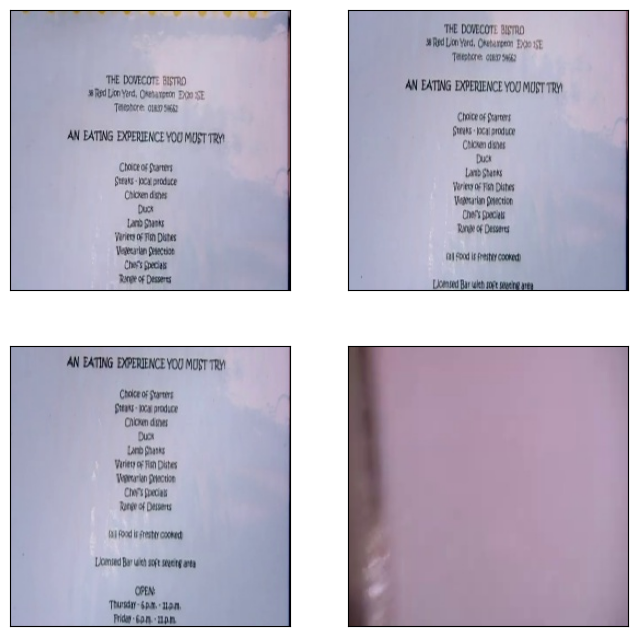

In [16]:
################## CHOSE A IMAGE BY INDEX TO SEARCH FOR ####################

INPUT_IMAGE_INDEX = 2110

###########################################################################

input_image = encoded_images[INPUT_IMAGE_INDEX]  # Example: use the first image as the input
nearest_neighbors = find_nearest_neighbors(encoded_images, input_image, top_n=5)

# Print the results
print("Nearest neighbors (index, distance):")
for neighbor in nearest_neighbors:
    print(neighbor)

top4 = [int(i[0]) for i in nearest_neighbors[:4]]
print(f"top 4: {top4}")

for i in top4:
  im = get_image(i)
  print(im["label"], im["timestamp"])

n=2
plt.figure(figsize=(8, 8))
for i, (image1, image2) in enumerate(zip(top4[:2], top4[2:])):
    ax = plt.subplot(2, n, i + 1)
    image1 = get_image(image1)["image"]
    image2 = get_image(image2)["image"]

    plt.imshow(image1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(image2)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [17]:
# Restart space to load new dataset, encoded images and model
from huggingface_hub import restart_space
restart_space("eybro/image_video_timestamp")

SpaceRuntime(stage='RUNNING_BUILDING', hardware='cpu-basic', requested_hardware='cpu-basic', sleep_time=172800, storage=None, raw={'stage': 'RUNNING_BUILDING', 'hardware': {'current': 'cpu-basic', 'requested': 'cpu-basic'}, 'storage': None, 'gcTimeout': 172800, 'replicas': {'current': 1, 'requested': 1}, 'devMode': False, 'domains': [{'domain': 'eybro-image-video-timestamp.hf.space', 'isCustom': False, 'stage': 'READY'}], 'sha': '109ef3d8364c7e6e89161091b33197ea93cc7dc9'})